## NN datos balanceados undersampling



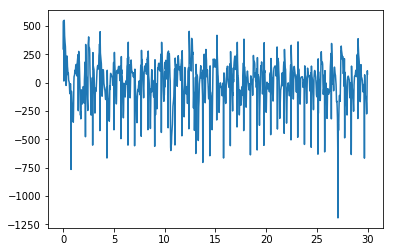

In [1]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. #hz
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
        X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()

In [2]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


In [4]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2],p = 0):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())  
        model.add(Dropout(p))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-3)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

/home/obarquero/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
## dev and train split

#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_resampled,y_resampled):
    X_train, X_dev = X_resampled[train], X_resampled[dev]
    y_train, y_dev = y_resampled[train], y_resampled[dev]
    
print(X_train.shape)
print(X_dev.shape)

(320, 9000)
(80, 9000)


In [6]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
n_h = [int(N/2),int(N/4),int(N/8),int(N/16),int(N/32)]
print(n_h)
print(N)
prob_dropout = 0.85
model = KerasClassifier(build_fn = create_model,N=N,n_hidd=n_h,p = prob_dropout,epochs = 1500, batch_size = 100, verbose = 1)

history = model.fit(X_train,y_train)

[4500, 2250, 1125, 562, 281]
9000
Epoch 1/1500
320/320 [==============================] - 11s 36ms/step - loss: 3.5048 - acc: 0.2688 - f1: 0.2391
Epoch 2/1500
320/320 [==============================] - 9s 28ms/step - loss: 3.4078 - acc: 0.2812 - f1: 0.2556
Epoch 3/1500
320/320 [==============================] - 10s 30ms/step - loss: 3.1110 - acc: 0.2625 - f1: 0.2460
Epoch 4/1500
320/320 [==============================] - 9s 27ms/step - loss: 3.0288 - acc: 0.2625 - f1: 0.2439
Epoch 5/1500
320/320 [==============================] - 9s 28ms/step - loss: 2.8587 - acc: 0.2969 - f1: 0.2783
Epoch 6/1500
320/320 [==============================] - 9s 27ms/step - loss: 2.6774 - acc: 0.2812 - f1: 0.2736
Epoch 7/1500
320/320 [==============================] - 8s 26ms/step - loss: 2.7593 - acc: 0.3219 - f1: 0.3129
Epoch 8/1500
320/320 [==============================] - 8s 26ms/step - loss: 2.4475 - acc: 0.3125 - f1: 0.2793
Epoch 9/1500
320/320 [==============================] - 9s 27ms/step - loss:

320/320 [==============================] - 8s 25ms/step - loss: 1.2412 - acc: 0.4500 - f1: 0.2824
Epoch 74/1500
320/320 [==============================] - 8s 26ms/step - loss: 1.2846 - acc: 0.4375 - f1: 0.2651
Epoch 75/1500
320/320 [==============================] - 8s 26ms/step - loss: 1.2619 - acc: 0.4187 - f1: 0.2913
Epoch 76/1500
320/320 [==============================] - 8s 25ms/step - loss: 1.2796 - acc: 0.4250 - f1: 0.2670
Epoch 77/1500
320/320 [==============================] - 8s 26ms/step - loss: 1.2138 - acc: 0.4344 - f1: 0.2746
Epoch 78/1500
320/320 [==============================] - 9s 27ms/step - loss: 1.2112 - acc: 0.4125 - f1: 0.3034
Epoch 79/1500
320/320 [==============================] - 8s 26ms/step - loss: 1.2198 - acc: 0.4219 - f1: 0.2731
Epoch 80/1500
320/320 [==============================] - 8s 25ms/step - loss: 1.2126 - acc: 0.4281 - f1: 0.2567
Epoch 81/1500
320/320 [==============================] - 8s 26ms/step - loss: 1.2914 - acc: 0.4188 - f1: 0.2697
Epoch 

320/320 [==============================] - 8s 26ms/step - loss: 0.5290 - acc: 0.7844 - f1: 0.7738
Epoch 146/1500
320/320 [==============================] - 8s 24ms/step - loss: 0.5452 - acc: 0.7906 - f1: 0.7826
Epoch 147/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.4836 - acc: 0.8312 - f1: 0.8113
Epoch 148/1500
320/320 [==============================] - 9s 27ms/step - loss: 0.6136 - acc: 0.7438 - f1: 0.7430
Epoch 149/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.4799 - acc: 0.8188 - f1: 0.8126
Epoch 150/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.5079 - acc: 0.8438 - f1: 0.8239
Epoch 151/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.5480 - acc: 0.8094 - f1: 0.7925
Epoch 152/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.4751 - acc: 0.8375 - f1: 0.8189
Epoch 153/1500
320/320 [==============================] - 9s 27ms/step - loss: 0.4401 - acc: 0.8437 - f1: 0.843

320/320 [==============================] - 8s 26ms/step - loss: 0.2541 - acc: 0.9250 - f1: 0.9234
Epoch 218/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.1910 - acc: 0.9344 - f1: 0.9342
Epoch 219/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.2076 - acc: 0.9375 - f1: 0.9375
Epoch 220/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.2730 - acc: 0.8906 - f1: 0.8856
Epoch 221/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.2449 - acc: 0.9125 - f1: 0.9142
Epoch 222/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.1487 - acc: 0.9469 - f1: 0.9469
Epoch 223/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.1255 - acc: 0.9750 - f1: 0.9765
Epoch 224/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.2993 - acc: 0.8969 - f1: 0.8934
Epoch 225/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.2208 - acc: 0.9063 - f1: 0.905

320/320 [==============================] - 9s 27ms/step - loss: 0.0975 - acc: 0.9719 - f1: 0.9700
Epoch 290/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.0858 - acc: 0.9750 - f1: 0.9733
Epoch 291/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.2000 - acc: 0.9375 - f1: 0.9390
Epoch 292/1500
320/320 [==============================] - 9s 27ms/step - loss: 0.0731 - acc: 0.9781 - f1: 0.9781
Epoch 293/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.1323 - acc: 0.9531 - f1: 0.9546
Epoch 294/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.1163 - acc: 0.9594 - f1: 0.9623
Epoch 295/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.0840 - acc: 0.9875 - f1: 0.9906
Epoch 296/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.1342 - acc: 0.9625 - f1: 0.9640
Epoch 297/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.0819 - acc: 0.9813 - f1: 0.981

320/320 [==============================] - 8s 26ms/step - loss: 0.0995 - acc: 0.9719 - f1: 0.9719
Epoch 362/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.0779 - acc: 0.9813 - f1: 0.9812
Epoch 363/1500
320/320 [==============================] - 9s 27ms/step - loss: 0.0728 - acc: 0.9719 - f1: 0.9734
Epoch 364/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.0528 - acc: 0.9813 - f1: 0.9843
Epoch 365/1500
320/320 [==============================] - 8s 25ms/step - loss: 0.0869 - acc: 0.9688 - f1: 0.9665
Epoch 366/1500
320/320 [==============================] - 9s 27ms/step - loss: 0.0564 - acc: 0.9844 - f1: 0.9828
Epoch 367/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.0498 - acc: 0.9844 - f1: 0.9844
Epoch 368/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.1822 - acc: 0.9625 - f1: 0.9593
Epoch 369/1500
320/320 [==============================] - 8s 26ms/step - loss: 0.0623 - acc: 0.9781 - f1: 0.976

320/320 [==============================] - 7s 21ms/step - loss: 0.0319 - acc: 0.9906 - f1: 0.9906
Epoch 434/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0393 - acc: 0.9875 - f1: 0.9859
Epoch 435/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0593 - acc: 0.9875 - f1: 0.9875
Epoch 436/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0523 - acc: 0.9781 - f1: 0.9781
Epoch 437/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0616 - acc: 0.9813 - f1: 0.9828
Epoch 438/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0743 - acc: 0.9750 - f1: 0.9765
Epoch 439/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.1165 - acc: 0.9719 - f1: 0.9719
Epoch 440/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0311 - acc: 0.9906 - f1: 0.9906
Epoch 441/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0642 - acc: 0.9812 - f1: 0.981

320/320 [==============================] - 7s 20ms/step - loss: 0.0560 - acc: 0.9813 - f1: 0.9781
Epoch 506/1500
320/320 [==============================] - 6s 19ms/step - loss: 0.0248 - acc: 0.9969 - f1: 0.9969
Epoch 507/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0346 - acc: 0.9937 - f1: 0.9937
Epoch 508/1500
320/320 [==============================] - 7s 20ms/step - loss: 0.0551 - acc: 0.9875 - f1: 0.9874
Epoch 509/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0800 - acc: 0.9812 - f1: 0.9843
Epoch 510/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0215 - acc: 0.9969 - f1: 0.9969
Epoch 511/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0582 - acc: 0.9906 - f1: 0.9906
Epoch 512/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.2235 - acc: 0.9594 - f1: 0.9635
Epoch 513/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0224 - acc: 0.9938 - f1: 0.993

320/320 [==============================] - 6s 20ms/step - loss: 0.0385 - acc: 0.9969 - f1: 0.9953
Epoch 578/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0393 - acc: 0.9906 - f1: 0.9922
Epoch 579/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.1070 - acc: 0.9719 - f1: 0.9686
Epoch 580/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.1791 - acc: 0.9813 - f1: 0.9812
Epoch 581/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0465 - acc: 0.9937 - f1: 0.9937
Epoch 582/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.1226 - acc: 0.9813 - f1: 0.9780
Epoch 583/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0723 - acc: 0.9813 - f1: 0.9797
Epoch 584/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0901 - acc: 0.9781 - f1: 0.9765
Epoch 585/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0452 - acc: 0.9875 - f1: 0.987

320/320 [==============================] - 6s 20ms/step - loss: 0.0203 - acc: 0.9938 - f1: 0.9937
Epoch 650/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0364 - acc: 0.9906 - f1: 0.9906
Epoch 651/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0248 - acc: 0.9938 - f1: 0.9953
Epoch 652/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0314 - acc: 0.9906 - f1: 0.9922
Epoch 653/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0525 - acc: 0.9938 - f1: 0.9937
Epoch 654/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0270 - acc: 0.9906 - f1: 0.9906
Epoch 655/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0215 - acc: 0.9969 - f1: 0.9984
Epoch 656/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0484 - acc: 0.9875 - f1: 0.9859
Epoch 657/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0481 - acc: 0.9875 - f1: 0.988

320/320 [==============================] - 6s 20ms/step - loss: 0.0186 - acc: 0.9938 - f1: 0.9937
Epoch 722/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0455 - acc: 0.9906 - f1: 0.9906
Epoch 723/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0465 - acc: 0.9875 - f1: 0.9875
Epoch 724/1500
320/320 [==============================] - 6s 19ms/step - loss: 0.0598 - acc: 0.9844 - f1: 0.9844
Epoch 725/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0272 - acc: 0.9875 - f1: 0.9891
Epoch 726/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0345 - acc: 0.9875 - f1: 0.9875
Epoch 727/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0424 - acc: 0.9906 - f1: 0.9906
Epoch 728/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0890 - acc: 0.9875 - f1: 0.9875
Epoch 729/1500
320/320 [==============================] - 7s 20ms/step - loss: 0.0471 - acc: 0.9812 - f1: 0.981

320/320 [==============================] - 7s 21ms/step - loss: 0.0154 - acc: 0.9938 - f1: 0.9922
Epoch 794/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0139 - acc: 0.9938 - f1: 0.9937
Epoch 795/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0220 - acc: 0.9938 - f1: 0.9937
Epoch 796/1500
320/320 [==============================] - 7s 20ms/step - loss: 0.0109 - acc: 1.0000 - f1: 1.0000
Epoch 797/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0029 - acc: 1.0000 - f1: 1.0000
Epoch 798/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0318 - acc: 0.9969 - f1: 0.9952
Epoch 799/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0058 - acc: 1.0000 - f1: 1.0000
Epoch 800/1500
320/320 [==============================] - 7s 22ms/step - loss: 0.0196 - acc: 0.9938 - f1: 0.9937
Epoch 801/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0110 - acc: 0.9969 - f1: 0.995

320/320 [==============================] - 7s 21ms/step - loss: 0.2442 - acc: 0.9625 - f1: 0.9625
Epoch 866/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0291 - acc: 0.9875 - f1: 0.9875
Epoch 867/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0437 - acc: 0.9875 - f1: 0.9875
Epoch 868/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0516 - acc: 0.9844 - f1: 0.9828
Epoch 869/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0929 - acc: 0.9813 - f1: 0.9812
Epoch 870/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0648 - acc: 0.9844 - f1: 0.9828
Epoch 871/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0270 - acc: 0.9906 - f1: 0.9906
Epoch 872/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0648 - acc: 0.9812 - f1: 0.9812
Epoch 873/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0898 - acc: 0.9875 - f1: 0.987

320/320 [==============================] - 7s 22ms/step - loss: 0.0750 - acc: 0.9844 - f1: 0.9844
Epoch 938/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0191 - acc: 0.9969 - f1: 0.9969
Epoch 939/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.1182 - acc: 0.9750 - f1: 0.9750
Epoch 940/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0382 - acc: 0.9844 - f1: 0.9828
Epoch 941/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0519 - acc: 0.9844 - f1: 0.9844
Epoch 942/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.1172 - acc: 0.9719 - f1: 0.9703
Epoch 943/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0676 - acc: 0.9844 - f1: 0.9828
Epoch 944/1500
320/320 [==============================] - 7s 20ms/step - loss: 0.0353 - acc: 0.9906 - f1: 0.9906
Epoch 945/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0203 - acc: 0.9906 - f1: 0.992

320/320 [==============================] - 6s 20ms/step - loss: 0.0694 - acc: 0.9844 - f1: 0.9844
Epoch 1010/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0138 - acc: 0.9938 - f1: 0.9937
Epoch 1011/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0505 - acc: 0.9875 - f1: 0.9859
Epoch 1012/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0513 - acc: 0.9906 - f1: 0.9906
Epoch 1013/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0473 - acc: 0.9813 - f1: 0.9843
Epoch 1014/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0839 - acc: 0.9813 - f1: 0.9827
Epoch 1015/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0242 - acc: 0.9938 - f1: 0.9937
Epoch 1016/1500
320/320 [==============================] - 7s 20ms/step - loss: 0.0515 - acc: 0.9938 - f1: 0.9937
Epoch 1017/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0339 - acc: 0.9938 - f

320/320 [==============================] - 7s 21ms/step - loss: 0.0033 - acc: 1.0000 - f1: 1.0000
Epoch 1082/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0228 - acc: 0.9969 - f1: 0.9969
Epoch 1083/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0476 - acc: 0.9813 - f1: 0.9812
Epoch 1084/1500
320/320 [==============================] - 7s 22ms/step - loss: 0.0961 - acc: 0.9906 - f1: 0.9906
Epoch 1085/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0438 - acc: 0.9906 - f1: 0.9906
Epoch 1086/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0047 - acc: 1.0000 - f1: 1.0000
Epoch 1087/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0033 - acc: 1.0000 - f1: 1.0000
Epoch 1088/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0511 - acc: 0.9906 - f1: 0.9906
Epoch 1089/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0385 - acc: 0.9906 - f

320/320 [==============================] - 6s 20ms/step - loss: 0.0203 - acc: 0.9969 - f1: 0.9969
Epoch 1154/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0224 - acc: 0.9938 - f1: 0.9937
Epoch 1155/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0054 - acc: 1.0000 - f1: 1.0000
Epoch 1156/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0263 - acc: 0.9938 - f1: 0.9953
Epoch 1157/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0111 - acc: 0.9969 - f1: 0.9969
Epoch 1158/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0053 - acc: 1.0000 - f1: 1.0000
Epoch 1159/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0137 - acc: 0.9969 - f1: 0.9969
Epoch 1160/1500
320/320 [==============================] - 6s 19ms/step - loss: 0.0315 - acc: 0.9938 - f1: 0.9922
Epoch 1161/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.1048 - acc: 0.9844 - f

320/320 [==============================] - 7s 21ms/step - loss: 0.0165 - acc: 0.9938 - f1: 0.9937
Epoch 1226/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0435 - acc: 0.9906 - f1: 0.9906
Epoch 1227/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0144 - acc: 0.9937 - f1: 0.9952
Epoch 1228/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.1654 - acc: 0.9750 - f1: 0.9750
Epoch 1229/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0042 - acc: 1.0000 - f1: 1.0000
Epoch 1230/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0913 - acc: 0.9875 - f1: 0.9875
Epoch 1231/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.1067 - acc: 0.9875 - f1: 0.9875
Epoch 1232/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.1017 - acc: 0.9906 - f1: 0.9906
Epoch 1233/1500
320/320 [==============================] - 7s 23ms/step - loss: 0.1218 - acc: 0.9844 - f

320/320 [==============================] - 6s 20ms/step - loss: 0.0470 - acc: 0.9906 - f1: 0.9906
Epoch 1298/1500
320/320 [==============================] - 7s 22ms/step - loss: 0.0162 - acc: 0.9938 - f1: 0.9937
Epoch 1299/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0021 - acc: 1.0000 - f1: 1.0000
Epoch 1300/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0143 - acc: 0.9938 - f1: 0.9937
Epoch 1301/1500
320/320 [==============================] - 7s 20ms/step - loss: 0.0354 - acc: 0.9844 - f1: 0.9844
Epoch 1302/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0071 - acc: 0.9969 - f1: 0.9969
Epoch 1303/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0162 - acc: 0.9969 - f1: 0.9969
Epoch 1304/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0437 - acc: 0.9938 - f1: 0.9937
Epoch 1305/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0536 - acc: 0.9938 - f

320/320 [==============================] - 7s 20ms/step - loss: 0.0534 - acc: 0.9938 - f1: 0.9937
Epoch 1370/1500
320/320 [==============================] - 7s 22ms/step - loss: 0.0333 - acc: 0.9938 - f1: 0.9937
Epoch 1371/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0513 - acc: 0.9906 - f1: 0.9906
Epoch 1372/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0235 - acc: 0.9938 - f1: 0.9922
Epoch 1373/1500
320/320 [==============================] - 7s 22ms/step - loss: 0.0127 - acc: 0.9969 - f1: 0.9953
Epoch 1374/1500
320/320 [==============================] - 6s 19ms/step - loss: 0.0117 - acc: 0.9969 - f1: 0.9969
Epoch 1375/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0040 - acc: 1.0000 - f1: 1.0000
Epoch 1376/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0104 - acc: 0.9969 - f1: 0.9969
Epoch 1377/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0187 - acc: 0.9938 - f

320/320 [==============================] - 6s 20ms/step - loss: 0.0834 - acc: 0.9844 - f1: 0.9844
Epoch 1442/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0612 - acc: 0.9875 - f1: 0.9875
Epoch 1443/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0383 - acc: 0.9938 - f1: 0.9937
Epoch 1444/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0726 - acc: 0.9844 - f1: 0.9828
Epoch 1445/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0326 - acc: 0.9969 - f1: 0.9969
Epoch 1446/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.0242 - acc: 0.9906 - f1: 0.9906
Epoch 1447/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0137 - acc: 0.9969 - f1: 0.9984
Epoch 1448/1500
320/320 [==============================] - 7s 21ms/step - loss: 0.1070 - acc: 0.9750 - f1: 0.9734
Epoch 1449/1500
320/320 [==============================] - 6s 20ms/step - loss: 0.0162 - acc: 0.9969 - f

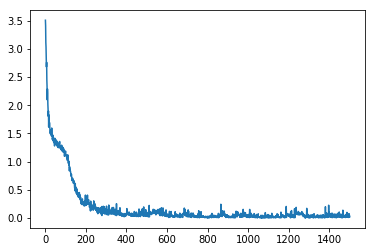

In [7]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)


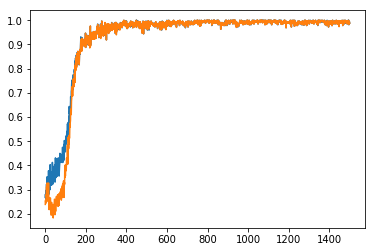

In [8]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)


In [9]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

320/320 [==============================] - 2s 5ms/step
accuracy:   1.000
classification report:
             precision    recall  f1-score   support

     Normal       1.00      1.00      1.00        80
         AF       1.00      1.00      1.00        80
      Other       1.00      1.00      1.00        80
      Noise       1.00      1.00      1.00        80

avg / total       1.00      1.00      1.00       320

confusion matrix:
[[80  0  0  0]
 [ 0 80  0  0]
 [ 0  0 80  0]
 [ 0  0  0 80]]


In [10]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

80/80 [==============================] - 0s 4ms/step
accuracy:   0.412
classification report:
             precision    recall  f1-score   support

     Normal       0.17      0.10      0.12        20
         AF       0.47      0.70      0.56        20
      Other       0.32      0.40      0.36        20
      Noise       0.69      0.45      0.55        20

avg / total       0.41      0.41      0.40        80

confusion matrix:
[[ 2  5 10  3]
 [ 4 14  2  0]
 [ 2  9  8  1]
 [ 4  2  5  9]]
